# Why we should use balances and machine learning for ionome diagnosis: the diagnosis of the ionome

This is the second of the two companion notebooks for the paper [*Why we should use balances and machine learning for ionome diagnosis*](https://www.authorea.com/users/23640/articles/281937-why-we-should-use-balances-and-machine-learning-for-ionome-diagnosis). In the paper, I present how isometric log-ratios can help the diagnosis of nutrient contents in plant tissues (the ionome), and how machine learning can detect important patterns in health diagnosis.

The computations for the diagnosis of the ionome are described in this second notebook 🥈, in the R statistical langage.

I need the **`tidyverse`** meta-package, the **`compositions`** package for compositional data preprocessing as well as the **`caret`** package for machine learning. The `codadend2.R` file contains a function named `CoDaDendrogram2`, which is a fork of the `compositions::CoDaDendrogram` function where I added some useful functions. The `ilrDefinition.R` file contains the `ilrDefinition` function, which I designed to help the naming of balances.

In [1]:
set.seed(7174108)

library("tidyverse")
library("compositions")
library("caret")
source("lib/codadend2.R")
source("lib/ilrDefinition.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: tensorA


Attaching package: ‘tensorA’


The following object is masked from ‘package:base’:

    norm


Loading required package: robustbase

Loading required package: bayesm

Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"



Attaching package: ‘compositions’


The following objects are masked from ‘package:stats’:

    cor, cov, dist, var


The following objects are masked from ‘package:base’:

    %*%, scale, scale.default


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked fro

The dataset consists in the composition of blueberry leaf tissues related to yield as health indicator.

In [2]:
df_source <- read_csv("data/blueberry.csv", na = c("", "NA", "."))

Parsed with column specification:
cols(
  .default = col_double(),
  Projet = col_character(),
  `Yield class` = col_character()
)

See spec(...) for full column specifications.



I put the column names in vectors to make things easier.

In [3]:
part_names <- c('N', 'P', 'K', 'Ca', 'Mg', 'Al', 'B', 'Cu', 'Zn', 'Mn', 'Fe', 'Mo')
performance <- c("Yield_kg.ha")

Oligo-elements were not recorded in the same scale as macro-elements. The following code chunk assures a common scale and computes a filling value, consisting in the amalgamation of the rest of elements in the leaves (mostly carbon and oxygen).

In [4]:
df <- df_source %>%
  select(part_names) %>%
  mutate(Al = Al/1000,
         B = B/1000,
         Cu = Cu/1000,
         Zn = Zn/1000,
         Mn = Mn/1000,
         Fe = Fe/1000,
         Mo = Mo/1000) %>%
  mutate(Fv = 100 - apply(., 1, sum),
         yield = df_source$Yield_kg.ha) %>%
  na.omit()

Now, Fv become a component as the others.

## Computing balances

In [5]:
part_names <- c(part_names, "Fv")

The `compositions::acomp` function assures that all rows sums to 1.

In [6]:
comp <- acomp(df %>% select(part_names))

The compute isometric log-ratios, we could use a default balance schema, but I usually prefer using my own. I encoded it in a sequential binary partition in a csv file.

In [7]:
sbp <- read_csv("data/sbp-blueberry.csv") %>% as.matrix()

Parsed with column specification:
cols(
  N = col_double(),
  P = col_double(),
  K = col_double(),
  Ca = col_double(),
  Mg = col_double(),
  Al = col_double(),
  B = col_double(),
  Cu = col_double(),
  Zn = col_double(),
  Fe = col_double(),
  Mn = col_double(),
  Mo = col_double(),
  Fv = col_double()
)



In [8]:
balance_names <- ilrDefinition(sbp, side = "-+")

In [9]:
psi <- gsi.buildilrBase(t(sbp))
balance <- ilr(comp, V=psi)

A balance dendrogram can be plotted with points grouped by yield. Lower points mean higher yields.

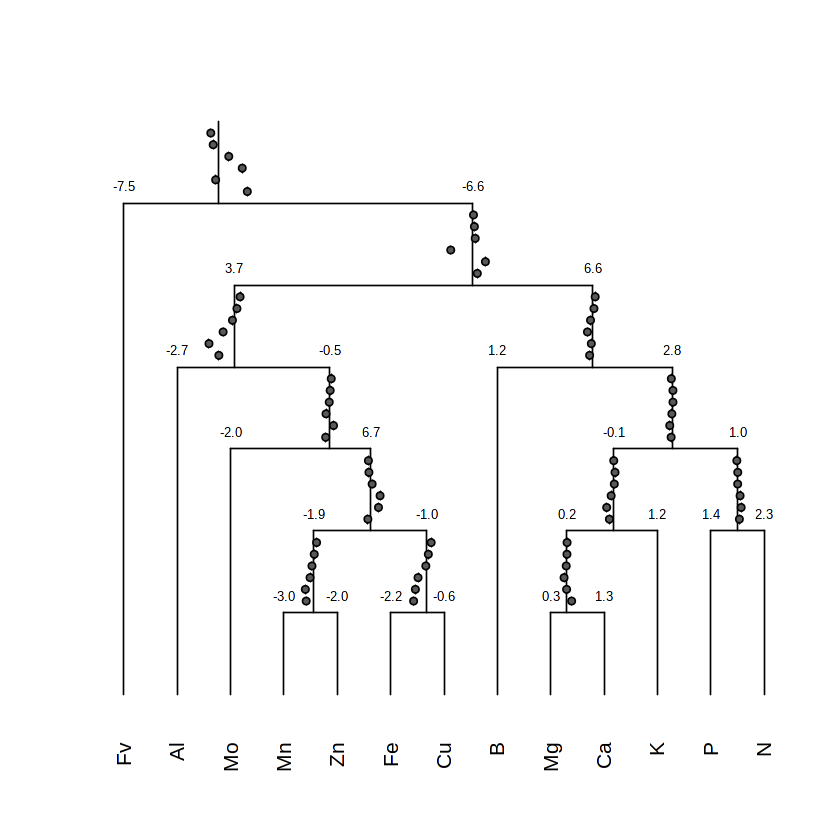

In [10]:
grouping <- cut(df$yield, breaks = 6)
CoDaDendrogram2(comp, V = psi,
                range = 'auto', equal.height = TRUE, type = 'conf', conf.level = 0, pch.col = FALSE,
                show.range = TRUE, group = grouping)

The first balance, [Fv | .], seems to influence yield. Higher yields are, at the bottom, tend to balance on the right. This is expected since elements are more present compared to Fv (the balance is on the side of elements). Also, yield seems to drop where Al occupies a large proportion of oligo-elements. In the same manner, the [Fe | Cu] balance seems also critical.

It should be noted that these interpretations, although valid, are univariate perspectives performed in the scope of this particular balance schema. We should always have in mind that a composition, like a set of balances, is intrisinquely multivariate.

## Setting the target

Yield is a continuous value. Predicting yield from the ionome could be useful. However, (1) it generally give poor results since a lot of confounding variables are affecting the prediction (fertilisation, weather, soil, diseases, pollination, etc.) and (2) categories facilitates decision-making. These categories can be formed in several manners. We could cut yield on one threshold, creating two categories as high-yielders and low-yielders. Yield can also be cut in several categories. The threshold(s) can be set according to the preference of the producers. Several models can be pre-trained according to these thresholds, or a producers could train their own models using a graphical user interface.

Here I'm using a single model which breaks yield in two categories based on a value close to the 65% quantile, i.e. 65% of yields are lower than the value shown.

In [11]:
quantile(df$yield, na.rm = TRUE, probs = c(0, 0.5, 0.65, 0.75, 1))

0%     50%     65%     75%    100% 
  649.0  3853.0  4887.8  5844.5 13830.0

Let's use 5000 kg/ha, which is a good yield, but bot an extraordinary one. Selecting a higher yield would decrease the size of high yielding data and may return highly constraining perturbation of the ionome.

In [12]:
df$yield_category <- cut(x = df$yield, breaks = c(0, 5000, 15000), labels = c("ly", "hy"))

## Computing the model

We create the table which will be used in the model. This table is formed with balances and the target.

In [13]:
df_ml <- data.frame(yield_category = df$yield_category,
                    balance)
df_ml %>% head()

yield_category V1        V2       V3       V4        V5       V6       
1 hy             -6.596987 3.827094 2.113198 0.4936190 1.827162 0.7944955
2 hy             -7.209578 5.891460 2.018160 0.3418462 1.922096 0.8962565
3 hy             -7.227635 5.369046 1.752159 0.4455405 2.070779 0.7926638
4 hy             -7.097240 5.203678 2.011295 0.5188767 1.943311 0.8104433
5 hy             -7.248210 6.120283 2.147542 0.3619570 1.901282 0.7116500
6 hy             -7.256380 6.366026 2.135933 0.1762332 1.840380 0.3010762
  V7        V8         V9        V10       V11       V12      
1 0.7312006 -0.7439221 -1.977567 -1.301548 -1.303845 -2.520713
2 0.7609455 -1.9447207  4.338623 -1.378157 -1.220707 -2.460043
3 0.5621003 -2.6370837  4.132447 -1.293221 -1.954259 -2.632864
4 0.5118879 -2.4968668  3.765447 -1.071738 -2.035344 -2.607762
5 0.7485482 -2.1400757  4.804385 -1.561570 -1.302108 -2.499063
6 1.3414664 -2.1239725  4.091331 -1.585548 -1.243471 -2.676253

The training samples are drawn randomly and constitutes 70% of the whole data set. The remaining 30% will be used to test the model.

In [14]:
train_id <- sample(1:nrow(df_ml), size = floor(0.7*nrow(df_ml)))

I'm using the **`caret`** package to create the model.

As in the islands example, I'm using a knn algorithm since it's a very straight forward approach. Other more sophisticated algorithms, like neural networks or xgboost, could have been used.

In [15]:
train_control <- trainControl(method = "cv",
                         number = 5,
                         savePredictions = TRUE,
                         search = "random")

In [16]:
ml_model_cat <- train(yield_category ~ .,
                      df_ml[train_id, ],
                      trControl = train_control,
                      method = "kknn",
                      tuneLength = 30,
                      verbose = FALSE)
ml_model_cat

k-Nearest Neighbors 

416 samples
 12 predictor
  2 classes: 'ly', 'hy' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 332, 333, 333, 333, 333 
Resampling results across tuning parameters:

  kmax  distance    kernel        Accuracy   Kappa    
    1   1.80158466  triangular    0.7187321  0.3828294
    7   0.01870254  triangular    0.6633964  0.2044080
   21   0.24925578  biweight      0.7619334  0.4318538
   23   1.44595612  inv           0.7355995  0.3531153
   29   2.05719958  gaussian      0.7308376  0.3339129
   39   2.31890771  biweight      0.7333046  0.3890715
   49   1.37395790  inv           0.7499713  0.3709976
   51   2.27383540  gaussian      0.7595238  0.3832085
   53   1.24062882  triangular    0.7571142  0.3852557
   53   2.58574822  biweight      0.7354848  0.3622187
   59   1.44374476  inv           0.7476477  0.3665241
   65   2.80644841  gaussian      0.7667527  0.3981105
   73   2.83826091  inv           0.7619334  0.3893886
   7

The confusion matrix is computed on test data.

In [17]:
confusionMatrix(df$yield_category[-train_id], predict(ml_model_cat, newdata = df_ml[-train_id, ])) 

Confusion Matrix and Statistics

          Reference
Prediction  ly  hy
        ly 104  13
        hy  30  32
                                          
               Accuracy : 0.7598          
                 95% CI : (0.6904, 0.8204)
    No Information Rate : 0.7486          
    P-Value [Acc > NIR] : 0.40326         
                                          
                  Kappa : 0.4329          
                                          
 Mcnemar's Test P-Value : 0.01469         
                                          
            Sensitivity : 0.7761          
            Specificity : 0.7111          
         Pos Pred Value : 0.8889          
         Neg Pred Value : 0.5161          
             Prevalence : 0.7486          
         Detection Rate : 0.5810          
   Detection Prevalence : 0.6536          
      Balanced Accuracy : 0.7436          
                                          
       'Positive' Class : ly              
                              

With an accuracy of 77%, results are pretty good. The model can be saved in a `RData` file then loaded for other analyses, e.g.:

In [18]:
save(ml_model_cat, file = "output/my_model.RData")

I also save my reference high yielders to be able to offer recommendations.

In [19]:
balance_hy <- balance[1:nrow(balance) %in% train_id & df_ml$yield_category == "hy", ] %>% data.frame()
write_csv(x = balance_hy, path = "output/my_ref.csv")

## Checking the health status of an observation

Now suppose that I'm sending a sample to the lab and they send me back the results. I load the model (e.g. `load(output/my_model.RData)`) and the libraries I need, than I predict the outcome.

In [20]:
observation <- c(N=1.5, P = 0.11, K = 0.42, Ca = 0.41, Mg = 0.18,
                 Al = 0.082, B = 0.041, Cu = 0.0052, Zn = 0.0068, Mn = 0.26,
                 Fe = 0.011, Mo = 0.00015) / 100

I compute the filling value.

In [21]:
observation <- c(observation, Fv = 1 - sum(observation))

I do the preprocessing by turning compositions to balances.

In [22]:
observation_bal <- unclass(ilr(acomp(observation), V = psi))

Then the prediction.

In [23]:
predict(ml_model_cat, newdata = observation_bal, type = "prob")

ly        hy       
1 0.7263816 0.2736184

A probability of 73% of falling in the low yielder category is enough to motivate me doing something, but what? Let's find the closest point in my traned model.

In [24]:
aitdist <- rep(0, nrow(balance_hy))
for (i in 1:nrow(balance_hy)) {
    aitdist[i] <- sqrt(sum((observation_bal - balance_hy[i, ])^2))
}

My misbalance index is

In [25]:
min(aitdist)

[1] 0.5583285

If I want the median of balances of the 10 closest points, as well as its related composition.

In [26]:
bal_top10 <- balance_hy[aitdist <= sort(aitdist)[10], ]
bal_ref <- apply(bal_top10, 2, median)
comp_ref <- unclass(ilrInv(bal_ref, V = psi))

In [27]:
comp_ref

N            P            K           Ca           Mg           Al 
1.652234e-02 1.275269e-03 5.893232e-03 4.671721e-03 1.796191e-03 5.247086e-04 
           B           Cu           Zn           Fe           Mn           Mo 
4.231495e-04 3.900028e-05 5.808763e-05 2.066064e-03 1.455053e-04 1.510706e-06 
          Fv 
9.665832e-01

I model the reference value to make sure it's a high yielder.

In [28]:
bal_ref_preddf <- data.frame(t(bal_ref))
colnames(bal_ref_preddf) <- paste0("V", 1:ncol(bal_ref_preddf))
predict(ml_model_cat, newdata = bal_ref_preddf, type = "prob")

ly        hy       
1 0.6499848 0.3500152

Let's check balances on the dendrogram. Since my algorithm to create the balance scema is not so sophisticated, I'm copying the reference several times to make sure that the vertical bars (automtically placed on the mean) are centered on the reference.

In [29]:
ref_stack <- comp_ref
for (i in 1:15) {
    ref_stack <- rbind(ref_stack, ref_stack)
}

In [30]:
comp_hy <- ilrInv(balance_hy, V = psi)

In [31]:
ref_stack <- rbind(ref_stack, comp_hy, observation, observation, observation)

In [32]:
grouping <- factor(rownames(ref_stack))

In [33]:
options(repr.plot.width = 10, repr.plot.height = 6)
png("images/coda_dendr_ref.png", width = 2000, height = 1000, res = 220)
CoDaDendrogram2(acomp(ref_stack), V = psi,
                range = 'auto', equal.height = TRUE, type = 'conf', conf.level = 0.95, pch.col = TRUE,
                show.range = TRUE, group = grouping)
legend(x = 9.5, y = 1.2, legend = c("High yielders", "Observation", "Reference"), c("red", "green", "blue"))
dev.off()

png 
  2

![](images/coda_dendr_ref.png)

It seems that the closest point is mostly outside the confidence range of the mean of high yielders. We can see taht we mostly should increase the [Al | .] balance, increase the [K,Ca,Mg, | P,N] balance an so on. But this is difficult to interpret. It's better to see it the the compositional scale, and to measure the distance to the reference in terms of compositional ratio.

In [34]:
recommend_df <- tibble(element = part_names, obs = observation, comp_ref) %>%
  mutate(ratio = obs / comp_ref)
recommend_df

element obs       comp_ref     ratio    
1  N       0.0150000 1.652234e-02 0.9078616
2  P       0.0011000 1.275269e-03 0.8625633
3  K       0.0042000 5.893232e-03 0.7126819
4  Ca      0.0041000 4.671721e-03 0.8776209
5  Mg      0.0018000 1.796191e-03 1.0021207
6  Al      0.0008200 5.247086e-04 1.5627720
7  B       0.0004100 4.231495e-04 0.9689247
8  Cu      0.0000520 3.900028e-05 1.3333237
9  Zn      0.0000680 5.808763e-05 1.1706451
10 Mn      0.0026000 2.066064e-03 1.2584316
11 Fe      0.0001100 1.455053e-04 0.7559862
12 Mo      0.0000015 1.510706e-06 0.9929132
13 Fv      0.9697385 9.665832e-01 1.0032644

In [35]:
recommend_df %>%
  mutate(obs = obs*100,
         comp_ref = comp_ref * 100) %>%
  mutate_if(is.numeric, function(x) signif(x, 2)) %>%
  rename(Nutrient = element,
         `Current concentration (%)` = obs,
         `Target concentration (%)` = comp_ref,
         `Current / Target ratio` = ratio) %>%
  write_csv(path = "output/example-observation.csv")

The change in composition is illustrated in the following barplot.

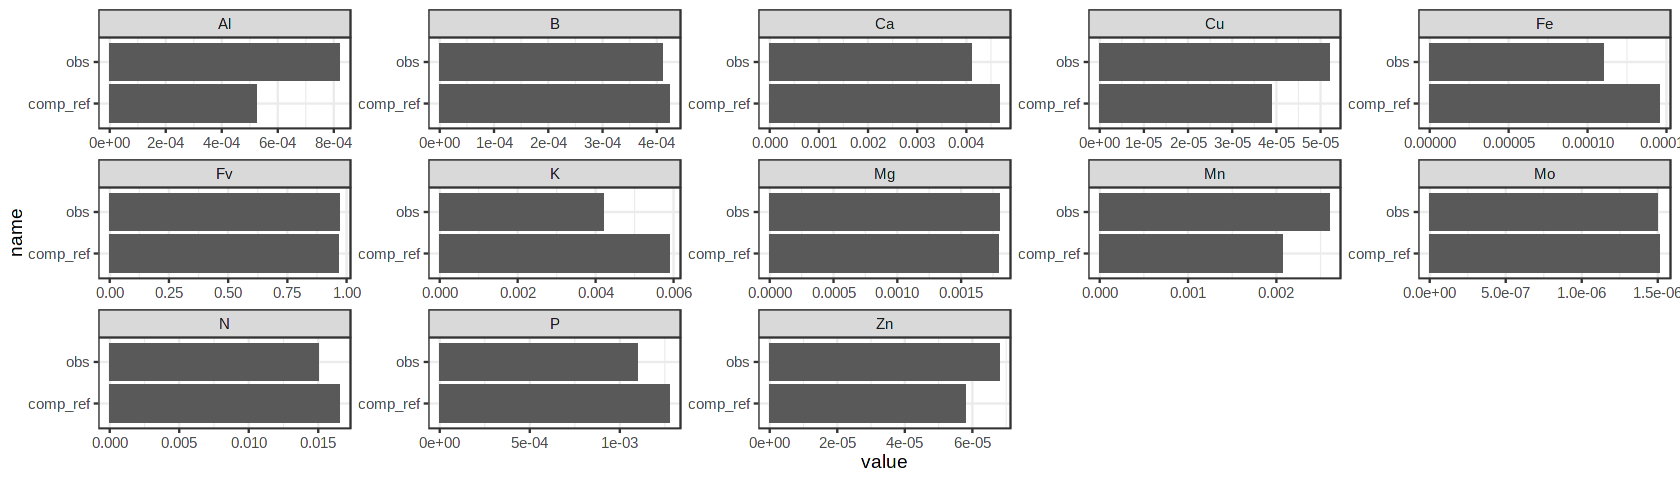

In [36]:
options(repr.plot.width = 14, repr.plot.height = 4)
recommend_df %>%
  select(-ratio) %>%
  pivot_longer(-element) %>%
  ggplot(aes(x = name, y = value)) +
  facet_wrap(~element, ncol = 5, scales = "free") +
  geom_bar(stat='identity') +
  coord_flip() +
  theme_bw()

Or a slope plot.

In [37]:
recommend_df_long <- recommend_df %>%
  select(-ratio) %>%
  rename(`Observation` = obs,
         `Target` = comp_ref) %>%
  #filter(element != "Fv") %>%
  pivot_longer(-element) %>%
  mutate(element = factor(element, levels=recommend_df$element))

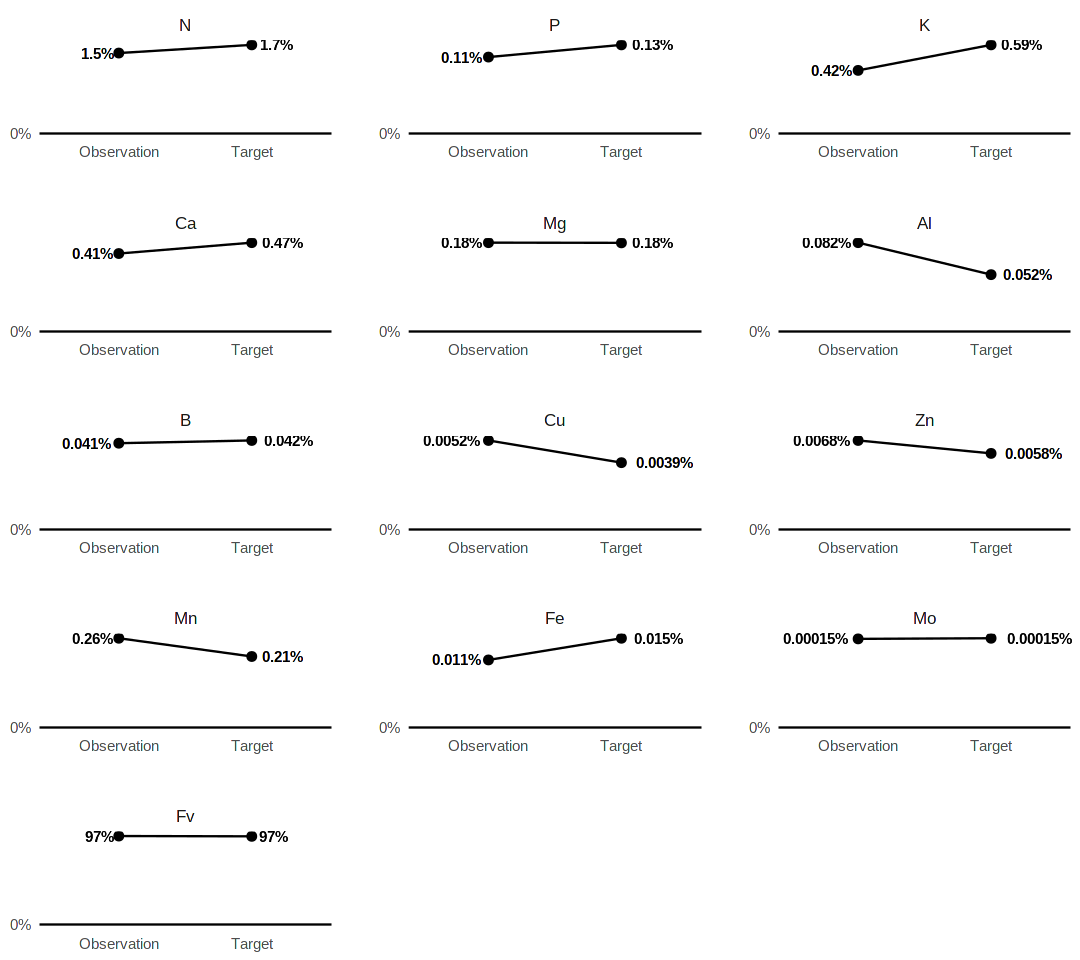

In [38]:
options(repr.plot.width = 9, repr.plot.height = 8)
recommend_df_long %>%
  ggplot(aes(x = name, y = value)) +
  facet_wrap(~element, ncol = 3, scales = "free") +
  geom_line(aes(group = element)) +
  geom_point(size=2) +
  expand_limits(y = 0) +
  geom_text(data = recommend_df_long %>% filter(name == "Observation"), 
            aes(label = paste0(signif(value*100, 2), "%")) , 
            hjust = 1.15, 
            fontface = "bold", 
            size = 3) +
  geom_text(data = recommend_df_long %>% filter(name == "Target"), 
            aes(label = paste0(signif(value*100, 2), "%")) , # element, " - ", 
            hjust = -0.25, 
            fontface = "bold", 
            size = 3) +
  scale_y_continuous(breaks=0, labels = scales::percent) +
  geom_hline(yintercept = 0) +
  theme_bw() +
  theme(axis.title.y = element_blank(),
        strip.text = element_text(size=10),
        panel.spacing = unit(10, 'mm'),
        panel.grid = element_blank(),
        panel.border = element_blank(),
        strip.background = element_rect(fill=NA, size=0),
        axis.title.x = element_blank(),
        panel.grid.major.x = element_blank(),
        axis.ticks = element_blank())
ggsave("images/comp_difference.png", width = 10, height = 8, dpi = 300)

But the distance from the reference can be better appreciate with the ratio and an ordered horizontal barplot.

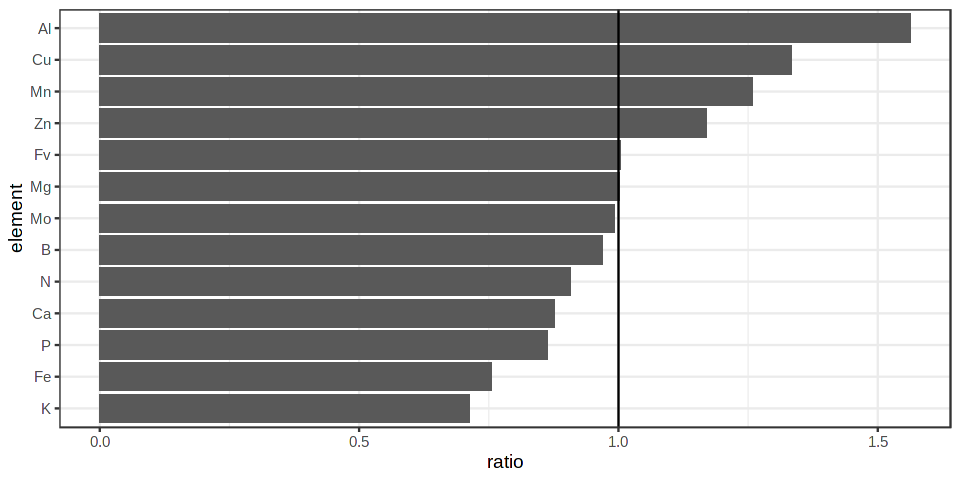

In [39]:
options(repr.plot.width = 8, repr.plot.height = 4)
recommend_df %>%
  mutate(element = fct_reorder(element, ratio)) %>%
  ggplot(aes(x = element, y = ratio)) +
  geom_bar(stat='identity') +
  geom_hline(yintercept = 1) +
  coord_flip() +
  theme_bw()
ggsave("images/comp_ratio.png", width = 14, height = 4, dpi = 300)